Here we will demonstrate how to effectively use linear mixed models in the context of balance trees.

This will cover how to specify different treatment effects in the linear mixed models, visualize them in
ETE, and diagnostic approaches for further investigating balances.

We'll start by loading up the modules required to run this notebook.

In [58]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from skbio.stats.composition import ilr, ilr_inv
from skbio import TreeNode
from gneiss.balances import balanceplot, balance_basis
from gneiss.layouts import barchart_layout
from gneiss.util import match, match_tips, rename_internal_nodes
from gneiss import mixedlm, ols

from biom import load_table
from ete3 import Tree, TreeStyle, NodeStyle, faces, AttrFace, CircleFace, BarChartFace
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Now we'll define a few convenience functions to cleaning up the metadata and matching the table to the metadata mapping file.

In [2]:
def convert_biom_to_pandas(table):
    """ Unpacks biom table into two pandas dataframes.
    
    The first dataframe will contain the count information for 
    features and samples. The second datafram will contain taxonomy 
    information for all of the OTUs.
    
    Parameters
    ----------
    table : biom.Table
    
    Returns
    -------
    pd.DataFrame
        Contingency table of counts where samples correspond 
        to rows and columns correspond to features (i.e. OTUs)
    pd.DataFrame
        A mapping of OTU names to taxonomic ids
    """

    feature_table = pd.DataFrame(np.array(table.matrix_data.todense()).T,
                             index=table.ids(axis='sample'),
                             columns=table.ids(axis='observation'))
    feature_ids = table.ids(axis='observation')
    mapping = {i: table.metadata(id=i, axis='observation')['taxonomy'] for i in feature_ids}
    # modify below as necessary.  
    # There are typically 7 levels of taxonomy.
    taxonomy = pd.DataFrame(mapping, 
                            index=['kingdom', 'phylum', 'class', 'order',
                                   'family', 'genus', 'species']).T
    return feature_table, taxonomy

Now, we will create some helper functions that we will use to create new columns in our metadata mapping file - namely for potato color and potato processing type.

This will upload the mapping file, the OTU table and the OTU tree into memory.

In [3]:
mapping = pd.read_table('../processed_data/1706_1145_mapping.txt', index_col=0)
table = load_table('../processed_data/1706_1145_otu_table.biom')
tree = TreeNode.read('../original_data/97_otus.tree')
mapping = mapping.set_index('#SampleID')

Now, we will filter out some of the samples in the metadata table, and add some additional columns for
processing type, potato color and time.

In [4]:
# filter out samples that aren't fecal
prevention_mapping = mapping.loc[mapping.body_site=='UBERON:feces']

# filter out control groups and blanks
prevention_mapping = prevention_mapping.loc[mapping.color!='Not applicable']
prevention_mapping = prevention_mapping.loc[prevention_mapping['processing'] != 'HCD']
prevention_mapping = prevention_mapping.loc[prevention_mapping['processing'] != 'Control']

Now we will filter out OTUs with less than 100 reads, and samples with less than 100 reads.

In [5]:
read_filter = lambda val, _id, md : sum(val) > 125
md_filter = lambda val, _id, md : _id in prevention_mapping.index

table.filter(md_filter, axis='sample') # filter out samples not in the mapping file.
table.filter(read_filter, axis='observation')
table.filter(read_filter, axis='sample')

2351 x 648 <class 'biom.table.Table'> with 651003 nonzero entries (42% dense)

We will convert the biom table into two pandas dataframes for the sake of readability.

In [6]:
otu_table, taxonomy = convert_biom_to_pandas(table)

otu_table, prevention_mapping = match(otu_table, prevention_mapping)
otu_table, otu_tree = match_tips(otu_table, tree)

Now we can directly run the linear mixed effects models.  Note, that there are some filtering steps being conducted
within this module to make sure that the sample names are aligned, and the OTU names are aligned with the tree.

In [7]:
#res = mixedlm("week + C(color, Treatment(reference='purple')) * C(processing, Treatment(reference='chipped'))",
#              otu_table + 1, prevention_mapping, otu_tree, groups='host_subject_id', n_jobs=64) 

In [8]:
import pickle
res = pickle.load(open('../results/prevention_time_mixedlm.pickle', 'rb'))
#pickle.dump(res, open('../results/prevention_time_mixedlm.pickle', 'wb'))

And now, we'll investigate the top 10 balances with the smallest p-values with respect to the processing method.

In [9]:
res.pvalues.sort_values(by="C(processing, Treatment(reference='chipped'))[T.baked]").head(10)

,"C(color, Treatment(reference='purple'))[T.white]","C(color, Treatment(reference='purple'))[T.white]:C(processing, Treatment(reference='chipped'))[T.baked]","C(color, Treatment(reference='purple'))[T.white]:C(processing, Treatment(reference='chipped'))[T.raw]","C(processing, Treatment(reference='chipped'))[T.baked]","C(processing, Treatment(reference='chipped'))[T.raw]",Intercept,Intercept RE,week
y2315,0.207085,0.051701,0.187250,0.000003,0.143173,7.031185e-16,9.995684e-01,1.673073e-03
y1593,0.166164,0.211389,0.064750,0.000010,0.000002,1.193137e-43,2.185792e-13,4.005490e-20
y1631,0.000056,0.000038,0.019936,0.000010,0.000023,2.381321e-63,9.997274e-01,3.645043e-13
y1790,0.401904,0.225324,0.017005,0.000036,0.000387,4.175791e-128,3.979561e-13,7.088507e-255
y1674,0.002221,0.003516,0.018830,0.000071,0.000002,2.967919e-44,5.934514e-13,9.875322e-03
y1961,0.520606,0.107776,0.238125,0.000079,0.000015,4.301937e-22,1.881326e-13,1.712130e-01
y1515,0.114439,0.001892,0.064760,0.000181,0.001278,8.023596e-04,5.441181e-14,4.806968e-04
y1934,0.541755,0.218786,0.420205,0.000197,0.000240,1.521617e-39,2.190206e-09,1.216762e-04
y549,0.644690,0.030038,0.607859,0.000204,0.000724,8.888854e-25,8.445853e-08,6.111696e-12
y1887,0.405368,0.171310,0.150027,0.000211,0.000048,4.501678e-54,9.998530e-01,6.317404e-03


We'll want to define a custom ETE layout to visualize the tree. The layout function to do this is defined below as follows.

In [10]:
def layout(node):
    """
    Specifies the layout for the ete.TreeStyle object.
    
    Parameters
    ----------
    node: ete.Tree
        Input node for specifying which attributes.
    """
    if node.is_leaf():
        # Add node name to leaf nodes
        #taxa = ';'.join(taxonomy.loc[node.name].values) + '(%s)' % node.name
        node.otu = "OTU_%s" % node.name
        N = AttrFace("otu", fsize=15, fgcolor='black')
        faces.add_face_to_node(N, node, 0)
        
    if "weight" in node.features:
        # Creates a sphere face whose size is proportional to node's
        # feature "weight"
        C = CircleFace(radius=node.weight*2, color="Red", style="sphere")
        # Let's make the sphere transparent
        C.opacity = 0.7
        # Rotate the faces by 90*
        C.rotation = 90
        # And place as a float face over the tree
        faces.add_face_to_node(C, node, 0, position="float")
        # highlight in blue, balances with pvalues that are outrageously small
        fsize = 12
        fgcolor = 'black'
        N = AttrFace("name", fsize=fsize, fgcolor=fgcolor)
        #faces.add_face_to_node(N, node, 0)

In [11]:
data = pd.merge(res.balances, prevention_mapping, left_index=True, right_index=True)
otu_tree = res.tree
nodes = {n.name:n for n in otu_tree.levelorder()}

childs = {}
for b in res.pvalues.sort_values(by="C(processing, Treatment(reference='chipped'))[T.baked]").head(20).index:
    childs[b] = {'left': len(list(nodes[b].children[0].tips())), 
                 'right':len(list(nodes[b].children[1].tips()))}
childs = pd.DataFrame(childs)

In [12]:
minb = 'y273'
nodes = {n.name:n for n in otu_tree.levelorder()}
subtree = nodes[minb] 
tips = [n.name for n in subtree.tips()]
non_tips = [n.name for n in subtree.levelorder() if not n.is_tip()]
sub_pvals = res.pvalues.loc[non_tips]

# Clostridium

Going to drop the baked, since it isn't as clear.

In [13]:
subdata = data.loc[data.processing!='baked']

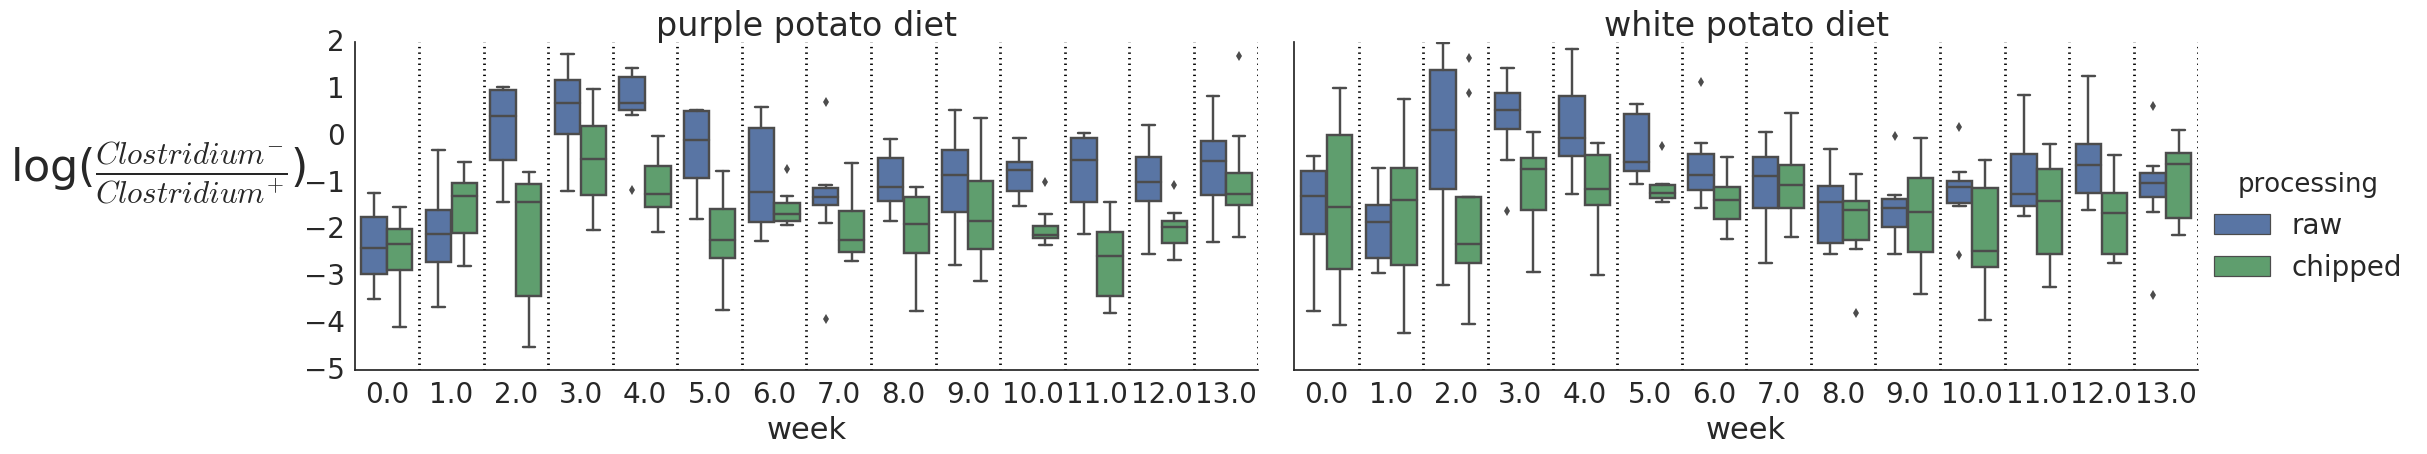

In [14]:
fig = plt.figure(figsize=(10, 10))
sns.set(font_scale=2)  
sns.set_style('white')
a = sns.factorplot(y=minb, x='week', hue='processing', col='color', 
                   data=subdata, kind='box', 
                   size=5, aspect=2)
a.axes[0][0].set_ylabel(r"log($\frac{Clostridium^{-}}{Clostridium^{+}}$)", 
                        fontsize=32, rotation=0, labelpad=105)
a.axes[0][0].set_title("purple potato diet", fontsize=24)
a.axes[0][1].set_title("white potato diet", fontsize=24)

minorLocator = matplotlib.ticker.AutoMinorLocator(2)
a.axes[0][0].get_xaxis().set_minor_locator(minorLocator)
a.axes[0][0].grid(axis='x', which='minor', color='k', linestyle=':', linewidth=2)
a.axes[0][1].get_xaxis().set_minor_locator(minorLocator)
a.axes[0][1].grid(axis='x', which='minor', color='k', linestyle=':', linewidth=2)
a.savefig('../results/clostridium.pdf')

In [15]:
means = subdata[[minb, 'week', 'color', 'processing']].groupby(['week', 'color', 'processing']).mean()

In [16]:
res.results[273].summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                      Mixed Linear Model Regression Results
==================================================================================================================================================
Model:                                           MixedLM                               Dependent Variable:                               y273     
No. Observations:                                648                                   Method:                                           REML     
No. Groups:                                      48                                    Scale:                                            1.0974   
Min. group size:                                 11                                    Likelihood:                                       -978.7110
Max. group size:                                 14                                    Converged:                                        Yes      
Mean group size:                                 13.5                                                                                             
--------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                               -1.785    0.179 -9.960 0.000 -2.136 -1.434
C(color, Treatment(reference='purple'))[T.white]                                                         0.267    0.235  1.138 0.255 -0.193  0.728
C(processing, Treatment(reference='chipped'))[T.baked]                                                   0.823    0.234  3.511 0.000  0.364  1.282
C(processing, Treatment(reference='chipped'))[T.raw]                                                     0.993    0.234  4.251 0.000  0.535  1.451
C(color, Treatment(reference='purple'))[T.white]:C(processing, Treatment(reference='chipped'))[T.baked] -0.570    0.331 -1.721 0.085 -1.219  0.079
C(color, Treatment(reference='purple'))[T.white]:C(processing, Treatment(reference='chipped'))[T.raw]   -0.322    0.331 -0.975 0.330 -0.970  0.326
week                                                                                                     0.003    0.010  0.304 0.761 -0.017  0.023
Intercept RE                                                                                             0.137    0.051                           
==================================================================================================================================================

"""

In [17]:
from statsmodels.sandbox.stats.multicomp import multipletests
cpvals = multipletests(res.pvalues["C(processing, Treatment(reference='chipped'))[T.raw]"],
                       method='fdr_bh')[1]
cpvals[273]

0.0020476832672964729

In [18]:
# Convert the p-values to negative log for better visualization.
column_name = "C(processing, Treatment(reference='chipped'))[T.raw]"
p = -np.log(sub_pvals[column_name].astype(np.float))

# Plot the balances for the subtree.
tr, ts = balanceplot(balances=p, tree=subtree, mode='r')  
ts.branch_vertical_margin = 10
ts.rotation=90
#tr.render(file_name='../figures/subfigures/clostridium_tree.pdf', tree_style=ts, layout=layout) 
#tr.render(file_name='%%inline', tree_style=ts, layout=layout) 

In [19]:
norm_table = otu_table.apply(lambda x: x / x.sum(), axis=1)
otu_data = pd.merge(norm_table, subdata, left_index=True, right_index=True)

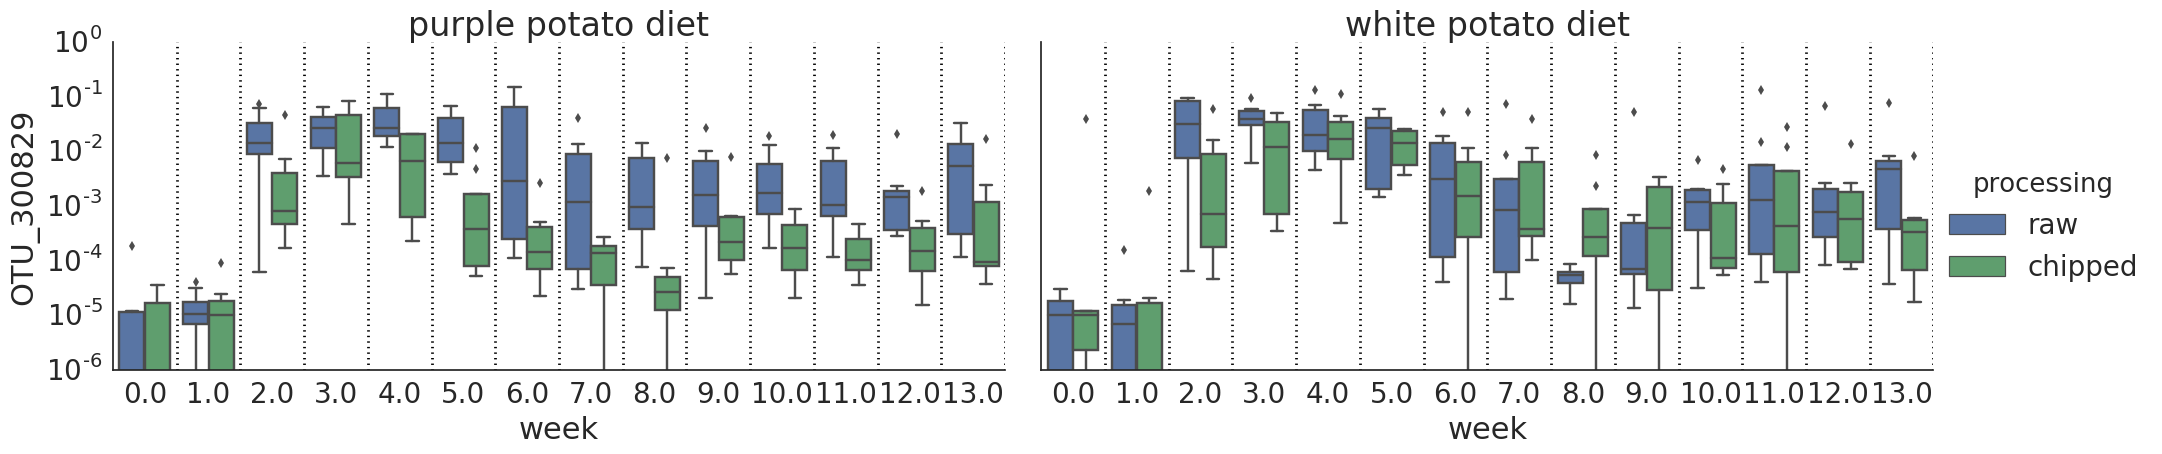

In [24]:
fig = plt.figure(figsize=(10, 5))
sns.set(font_scale=2) 
sns.set_style('white')
a = sns.factorplot(y='300829', x='week', hue='processing', col='color', data=otu_data, kind='box', size=5, aspect=2)
a.axes[0][0].set_ylabel('OTU_300829')
a.axes[0][0].set_yscale('log')
a.axes[0][1].set_yscale('log') 
a.axes[0][0].set_title("purple potato diet", fontsize=24)
a.axes[0][1].set_title("white potato diet", fontsize=24)
minorLocator = matplotlib.ticker.AutoMinorLocator(2)
a.axes[0][0].get_xaxis().set_minor_locator(minorLocator)
a.axes[0][0].grid(axis='x', which='minor', color='k', linestyle=':', linewidth=2)
a.axes[0][1].get_xaxis().set_minor_locator(minorLocator)
a.axes[0][1].grid(axis='x', which='minor', color='k', linestyle=':', linewidth=2)
a.savefig('../results/OTU_300829.pdf')

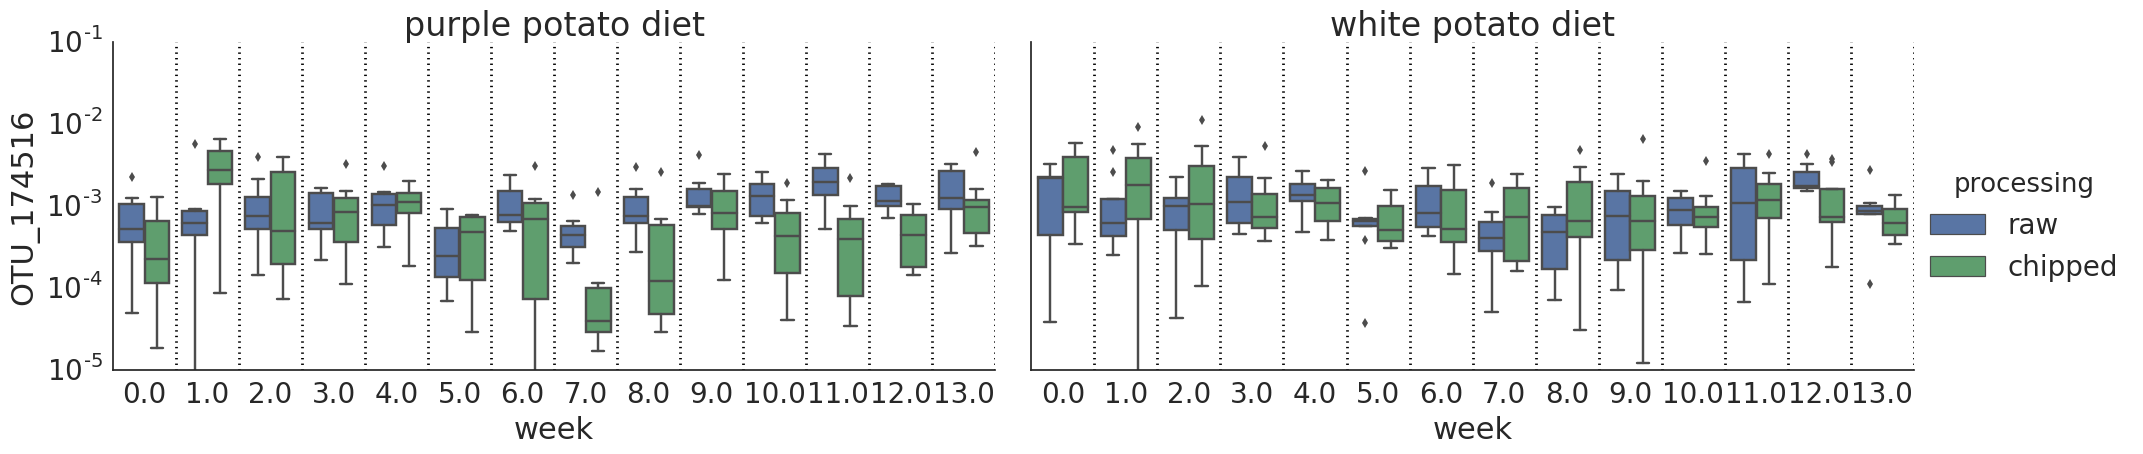

In [25]:
fig = plt.figure(figsize=(10, 5))
sns.set(font_scale=2)
sns.set_style('white')

a = sns.factorplot(y='174516', x='week', hue='processing', col='color', data=otu_data, kind='box', size=5, aspect=2)
a.axes[0][0].set_ylabel('OTU_174516')
a.axes[0][0].set_yscale('log')
a.axes[0][1].set_yscale('log')
a.axes[0][0].set_title("purple potato diet", fontsize=24)
a.axes[0][1].set_title("white potato diet", fontsize=24)
minorLocator = matplotlib.ticker.AutoMinorLocator(2)
a.axes[0][0].get_xaxis().set_minor_locator(minorLocator)
a.axes[0][0].grid(axis='x', which='minor', color='k', linestyle=':', linewidth=2)
a.axes[0][1].get_xaxis().set_minor_locator(minorLocator)
a.axes[0][1].grid(axis='x', which='minor', color='k', linestyle=':', linewidth=2)
a.savefig('../results/OTU_174516.pdf')
#a.savefig('../results/chipped_%s_plot.pdf' % minb)

# Mogibacteriaceae

In [26]:
minb = 'y543'
nodes = {n.name:n for n in otu_tree.levelorder()}
subtree = nodes[minb] 
tips = [n.name for n in subtree.tips()]
non_tips = [n.name for n in subtree.levelorder() if not n.is_tip()]
sub_pvals = res.pvalues.loc[non_tips]

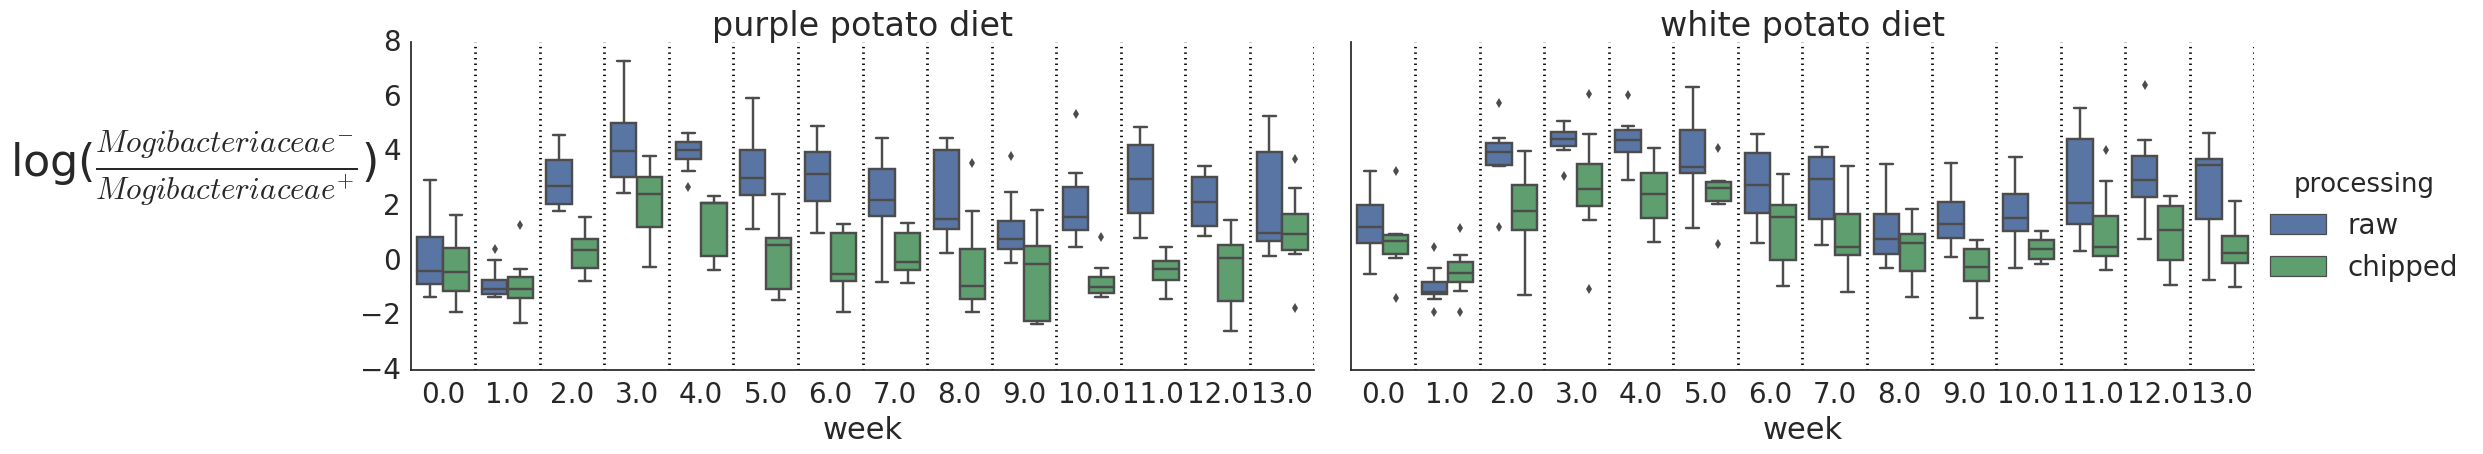

In [28]:
fig = plt.figure(figsize=(10, 5))
sns.set_style('white')

a = sns.factorplot(y=minb, x='week', hue='processing', col='color', 
                   data=subdata, kind='box', 
                   size=5, aspect=2)
a.axes[0][0].set_ylabel(r"log($\frac{Mogibacteriaceae^{-}}{Mogibacteriaceae^{+}}$)", 
                        fontsize=32, rotation=0, labelpad=120)
a.axes[0][0].set_title("purple potato diet", fontsize=24)
a.axes[0][1].set_title("white potato diet", fontsize=24)

minorLocator = matplotlib.ticker.AutoMinorLocator(2)
a.axes[0][0].get_xaxis().set_minor_locator(minorLocator)
a.axes[0][0].grid(axis='x', which='minor', color='k', linestyle=':', linewidth=2)
a.axes[0][1].get_xaxis().set_minor_locator(minorLocator)
a.axes[0][1].grid(axis='x', which='minor', color='k', linestyle=':', linewidth=2)

a.savefig('../results/mogibacteriaceae.pdf')

In [29]:
taxonomy.loc[[n.name for n in nodes[minb].children[0].tips()]]

,kingdom,phylum,class,order,family,genus,species
302433,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
4455005,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
36792,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
300285,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
4311953,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
33133,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
208539,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
673084,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
351498,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
97639,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__


In [30]:
taxonomy.loc[[n.name for n in nodes[minb].children[1].tips()]]

,kingdom,phylum,class,order,family,genus,species
300588,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
23113,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
811513,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__
2176015,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__Mogibacterium,s__
1084643,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__Mogibacterium,s__
324882,k__Bacteria,p__Firmicutes,c__Clostridia,o__Clostridiales,f__[Mogibacteriaceae],g__,s__


In [32]:
means = subdata[[minb, 'week', 'color', 'processing']].groupby(['week', 'color', 'processing']).mean()

In [33]:
#raw = means.xs('raw', level='processing')
idx = pd.IndexSlice
raw_purple     = means.loc[idx[:, 'purple', 'raw'], :]
chipped_purple = means.loc[idx[:, 'purple', 'chipped'], :]
raw_white      = means.loc[idx[:, 'white', 'raw'], :]
chipped_white  = means.loc[idx[:, 'white', 'chipped'], :]

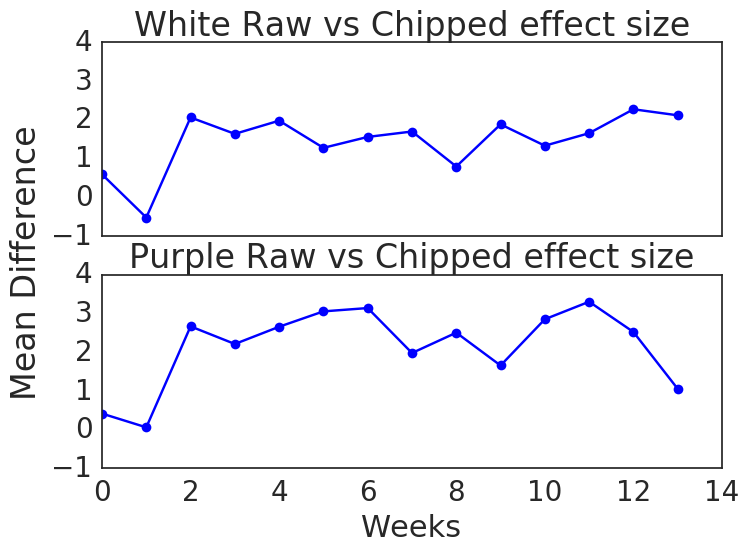

In [34]:
f, axes = plt.subplots(2, sharex=True, sharey=True)
axes[0].plot(np.arange(14), (raw_white.values - chipped_white.values), '-ob')
axes[0].set_title('White Raw vs Chipped effect size')
#axes[0].set_ylabel('Mean balance difference')
#axes[0].set_xlabel('Weeks')

axes[1].plot(np.arange(14), (raw_purple.values - chipped_purple.values), '-ob')
axes[1].set_title('Purple Raw vs Chipped effect size')
#axes[1].set_ylabel('Mean balance difference')
axes[1].set_xlabel('Weeks')
f.text(0.01, 0.5, 'Mean Difference', va='center', rotation='vertical')
plt.locator_params(axis='y',nbins=5)

In [35]:
# Convert the p-values to negative log for better visualization.
column_name = "C(processing, Treatment(reference='chipped'))[T.raw]"
p = -np.log(sub_pvals[column_name].astype(np.float))

# Plot the balances for the subtree.
tr, ts = balanceplot(balances=p, tree=subtree, mode='r')  
ts.branch_vertical_margin = 10
ts.rotation=90
#tr.render(file_name='../results/mogibacteriaceae_tree.pdf', tree_style=ts, layout=layout) 
#tr.render(file_name='%%inline', tree_style=ts, layout=layout) 

In [36]:
res.results[543].summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                      Mixed Linear Model Regression Results
==================================================================================================================================================
Model:                                          MixedLM                               Dependent Variable:                               y543      
No. Observations:                               648                                   Method:                                           REML      
No. Groups:                                     48                                    Scale:                                            2.6047    
Min. group size:                                11                                    Likelihood:                                       -1263.2913
Max. group size:                                14                                    Converged:                                        Yes       
Mean group size:                                13.5                                                                                              
--------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                0.209    0.323  0.647 0.518 -0.424  0.842
C(color, Treatment(reference='purple'))[T.white]                                                         0.905    0.433  2.091 0.036  0.057  1.752
C(processing, Treatment(reference='chipped'))[T.baked]                                                   1.520    0.432  3.521 0.000  0.674  2.366
C(processing, Treatment(reference='chipped'))[T.raw]                                                     2.144    0.431  4.976 0.000  1.299  2.988
C(color, Treatment(reference='purple'))[T.white]:C(processing, Treatment(reference='chipped'))[T.baked] -1.631    0.610 -2.673 0.008 -2.828 -0.435
C(color, Treatment(reference='purple'))[T.white]:C(processing, Treatment(reference='chipped'))[T.raw]   -0.674    0.610 -1.105 0.269 -1.868  0.521
week                                                                                                    -0.010    0.016 -0.606 0.545 -0.040  0.021
Intercept RE                                                                                             0.549    0.113                           
==================================================================================================================================================

"""

In [37]:
from statsmodels.sandbox.stats.multicomp import multipletests
cpvals = multipletests(res.pvalues["C(processing, Treatment(reference='chipped'))[T.raw]"],
                       method='fdr_bh')[1]
cpvals[543]

0.00030470596777071692

# Body site correlations

Here, we will run the balance trees on the proximal and distal samples.  We'll then correlate the distal samples with the various hormone and inflammation markers.

In [71]:
mapping = pd.read_table('../processed_data/1706_1145_mapping.txt', index_col=0)
table = load_table('../processed_data/1706_1145_otu_table.biom')
tree = TreeNode.read('../original_data/97_otus.tree')
mapping = mapping.set_index('#SampleID')

In [72]:
# filter out samples that aren't on the final timepoint
final_mapping = mapping.loc[mapping.week==14]

# filter out control groups and blanks
final_mapping = final_mapping.loc[final_mapping.color!='Not applicable']
final_mapping = final_mapping.loc[final_mapping.body_site!='UBERON:ileum']

final_mapping = final_mapping.loc[final_mapping['processing'] != 'HCD']
final_mapping = final_mapping.loc[final_mapping['processing'] != 'Control']

In [73]:
read_filter = lambda val, _id, md : sum(val) > 125
md_filter = lambda val, _id, md : _id in final_mapping.index

table.filter(md_filter, axis='sample') # filter out samples not in the mapping file.
table.filter(read_filter, axis='sample')
table.filter(read_filter, axis='observation')

1099 x 92 <class 'biom.table.Table'> with 66196 nonzero entries (65% dense)

In [74]:
otu_table, taxonomy = convert_biom_to_pandas(table)

In [75]:
#res = mixedlm("C(body_site) + C(color, Treatment(reference='purple')) * C(processing, Treatment(reference='chipped'))",
#              otu_table + 1, final_mapping, otu_tree, groups='host_subject_id', n_jobs=64) 
#pickle.dump(res, open('../results/prevention_bodysite_mixedlm.pickle', 'wb'))

In [76]:
#pickle.dump(res, open('../results/prevention_bodysite_mixedlm.pickle', 'wb'))

In [97]:
data = pd.merge(res.balances, final_mapping, left_index=True, right_index=True)
otu_tree = res.tree
nodes = {n.name:n for n in otu_tree.levelorder()}

childs = {}
for b in res.pvalues.sort_values(by="C(processing, Treatment(reference='chipped'))[T.baked]").index:
    childs[b] = {'left': len(list(nodes[b].children[0].tips())), 
                 'right':len(list(nodes[b].children[1].tips()))}
childs = pd.DataFrame(childs)
pvals = pd.merge(res.pvalues, childs.T, left_index=True, right_index=True)

In [98]:
pvals

,C(body_site)[T.UBERON:proximal colon],"C(color, Treatment(reference='purple'))[T.white]","C(color, Treatment(reference='purple'))[T.white]:C(processing, Treatment(reference='chipped'))[T.baked]","C(color, Treatment(reference='purple'))[T.white]:C(processing, Treatment(reference='chipped'))[T.raw]","C(processing, Treatment(reference='chipped'))[T.baked]","C(processing, Treatment(reference='chipped'))[T.raw]",Intercept,Intercept RE,left,right
y0,1.264919e-11,0.041420,0.044299,0.004539,0.342831,0.000669,2.185806e-05,0.057568,7,1068
y100,6.243245e-01,0.019907,0.017475,0.229923,0.894805,0.998529,2.715290e-04,0.051292,3,2
y1002,9.548678e-01,0.904961,0.928948,0.550835,0.330178,0.029611,5.407404e-03,0.137948,2,0
y1006,3.392477e-02,0.061606,0.006311,0.160741,0.022869,0.324932,1.107949e-03,0.145663,2,4
y1009,6.789707e-03,0.524442,0.674069,0.046424,0.545308,0.218976,1.905447e-02,0.099983,16,2
y1012,3.750128e-02,0.420391,0.983036,0.725498,0.413140,0.085247,1.583329e-07,0.138555,0,0
y1013,7.702379e-01,0.709388,0.376630,0.698149,0.202584,0.156272,1.788154e-04,0.133837,0,0
y1014,6.640143e-02,0.597419,0.467511,0.684389,0.601601,0.527218,3.676480e-02,0.105564,0,0
y1015,1.979773e-01,0.409201,0.021363,0.728095,0.031583,0.295274,1.548583e-02,0.103523,3,0
y1017,2.834329e-01,0.856110,0.563612,0.838082,0.012564,0.011001,2.896456e-08,0.070773,6,2


In [120]:
colname = "C(processing, Treatment(reference='chipped'))[T.raw]"
pvals[[colname, 'left', 'right']].sort_values(by=colname).head(15)

,"C(processing, Treatment(reference='chipped'))[T.raw]",left,right
y2247,4.916417e-07,2,0
y1577,8.429383e-07,4,0
y809,3.584823e-06,9,0
y408,4.563038e-06,9,0
y1791,9.513415e-06,0,14
y276,1.363261e-05,15,0
y2233,1.490126e-05,0,0
y1693,1.863066e-05,0,0
y864,2.654332e-05,0,8
y620,2.837027e-05,3,6


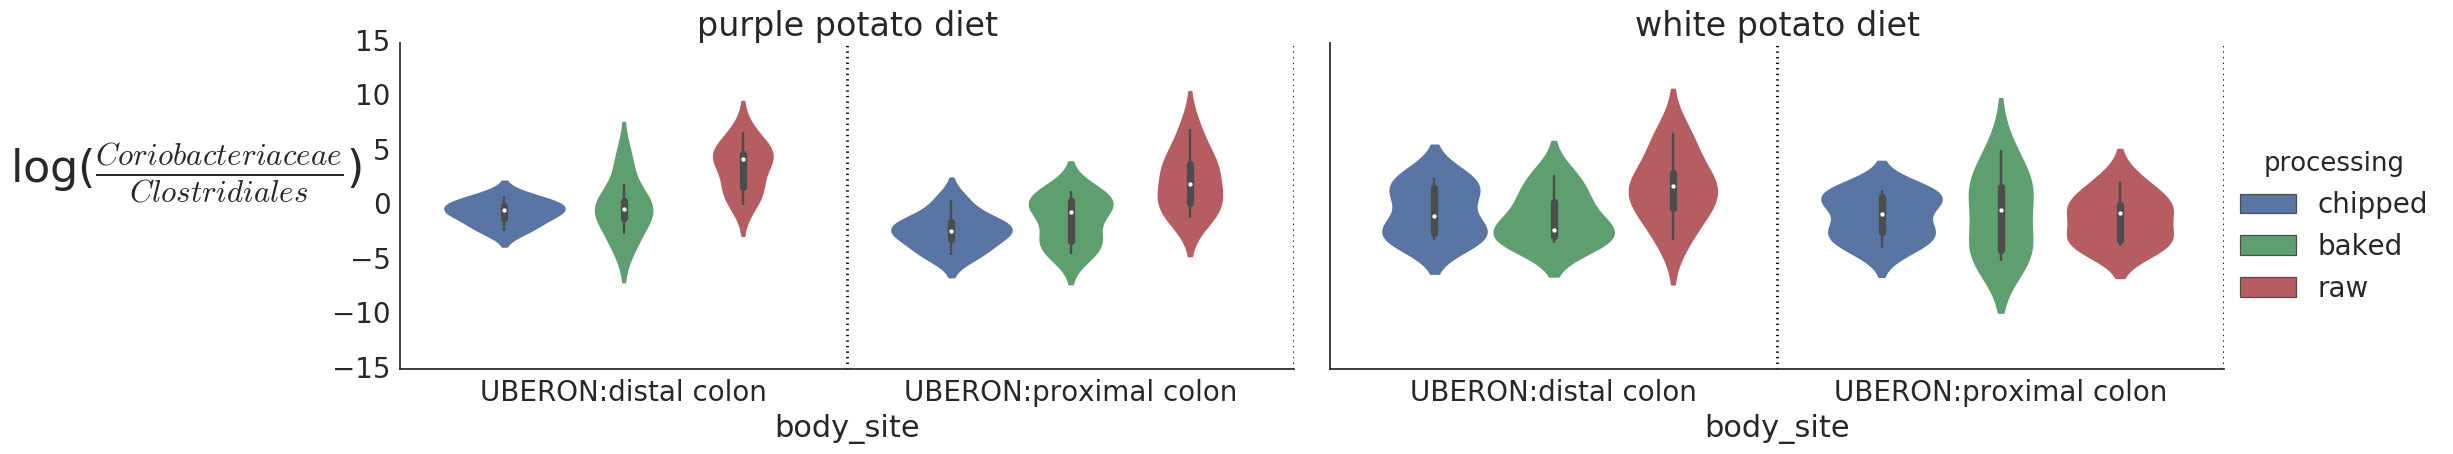

In [118]:
minb='y233'

fig = plt.figure(figsize=(10, 10))
sns.set(font_scale=2)  
sns.set_style('white')
a = sns.factorplot(y=minb, x='body_site', hue='processing', col='color', 
                   data=data, kind='violin', 
                   size=5, aspect=2)
a.axes[0][0].set_ylabel(r"log($\frac{Coriobacteriaceae}{Clostridiales}$)", 
                        fontsize=32, rotation=0, labelpad=105)
a.axes[0][0].set_title("purple potato diet", fontsize=24)
a.axes[0][1].set_title("white potato diet", fontsize=24)

minorLocator = matplotlib.ticker.AutoMinorLocator(2)
a.axes[0][0].get_xaxis().set_minor_locator(minorLocator)
a.axes[0][0].grid(axis='x', which='minor', color='k', linestyle=':', linewidth=2)
a.axes[0][1].get_xaxis().set_minor_locator(minorLocator)
a.axes[0][1].grid(axis='x', which='minor', color='k', linestyle=':', linewidth=2)
a.savefig('../results/y233.pdf')

In [111]:
taxonomy.loc[[n.name for n in nodes[minb].children[1].tips()]]

,kingdom,phylum,class,order,family,genus,species
4335376,k__Bacteria,p__Actinobacteria,c__Coriobacteriia,o__Coriobacteriales,f__Coriobacteriaceae,g__,s__
4481613,k__Bacteria,p__Actinobacteria,c__Coriobacteriia,o__Coriobacteriales,f__Coriobacteriaceae,g__Collinsella,s__aerofaciens
3102225,k__Bacteria,p__Actinobacteria,c__Coriobacteriia,o__Coriobacteriales,f__Coriobacteriaceae,g__,s__
4432463,k__Bacteria,p__Actinobacteria,c__Coriobacteriia,o__Coriobacteriales,f__Coriobacteriaceae,g__,s__
365033,k__Bacteria,p__Actinobacteria,c__Coriobacteriia,o__Coriobacteriales,f__Coriobacteriaceae,g__,s__
584954,k__Bacteria,p__Actinobacteria,c__Coriobacteriia,o__Coriobacteriales,f__Coriobacteriaceae,g__,s__
4441081,k__Bacteria,p__Actinobacteria,c__Coriobacteriia,o__Coriobacteriales,f__Coriobacteriaceae,g__,s__
4361768,k__Bacteria,p__Actinobacteria,c__Coriobacteriia,o__Coriobacteriales,f__Coriobacteriaceae,g__,s__
617216,k__Bacteria,p__Actinobacteria,c__Coriobacteriia,o__Coriobacteriales,f__Coriobacteriaceae,g__,s__
288683,k__Bacteria,p__Actinobacteria,c__Coriobacteriia,o__Coriobacteriales,f__Coriobacteriaceae,g__,s__


In [117]:
taxonomy.loc[[n.name for n in nodes[minb].children[0].tips()]].order.value_counts()

o__Clostridiales         597
o__Erysipelotrichales     23
Name: order, dtype: int64

Alright, looks like there is a difference with respect to the purple potato diet, but not in the white potato diet.
What does this look like when we factor in inflammation?

# Distal colon inflammation regression

We'll now only look at the distal colon, and perform regression on the inflammation factors.

In [173]:
mapping = pd.read_table('../processed_data/1706_1145_mapping.txt', index_col=0)
table = load_table('../processed_data/1706_1145_otu_table.biom')
tree = TreeNode.read('../original_data/97_otus.tree')
mapping = mapping.set_index('#SampleID')

In [174]:
# filter out control groups and blanks
final_mapping = mapping.loc[mapping.color!='Not applicable']
final_mapping = final_mapping.loc[final_mapping.body_site=='UBERON:distal colon']
final_mapping = final_mapping.loc[final_mapping['processing'] != 'HCD']
final_mapping = final_mapping.loc[final_mapping['processing'] != 'Control']

In [175]:
read_filter = lambda val, _id, md : sum(val) > 125
md_filter = lambda val, _id, md : _id in final_mapping.index

table.filter(md_filter, axis='sample') # filter out samples not in the mapping file.
table.filter(read_filter, axis='sample')
table.filter(read_filter, axis='observation')

831 x 45 <class 'biom.table.Table'> with 28270 nonzero entries (75% dense)

In [176]:
final_mapping = final_mapping.rename(columns={'Final weight at the end of study':'weight'})
final_mapping = final_mapping.rename(columns={'Stem cells':'stem_cells'})
final_mapping = final_mapping.rename(columns={'TGF-a':'TGF_a'})
final_mapping = final_mapping.rename(columns={'TLR-2':'TLR_2'})
final_mapping = final_mapping.rename(columns={'TLR-4':'TLR_4'})
final_mapping = final_mapping.rename(columns={'NF-kB':'NF_kB'})

In [177]:
otu_table, taxonomy = convert_biom_to_pandas(table)
otu_table, final_mapping = match(otu_table, final_mapping)
otu_table, otu_tree = match_tips(otu_table, tree)

In [179]:
formula = ("C(color, Treatment(reference='purple')) + C(processing, Treatment(reference='chipped'))"
           " + weight + TGF_a + TLR_2 + TLR_4 + NF_kB")
res = ols(formula, otu_table + 1, final_mapping, otu_tree, n_jobs=64) 

In [180]:
pickle.dump(res, open('../results/distal_inflammation_regression.pickle', 'wb')) 

In [181]:
data = pd.merge(res.balances, final_mapping, left_index=True, right_index=True)
otu_tree = res.tree
nodes = {n.name:n for n in otu_tree.levelorder()}

childs = {}
for b in res.pvalues.sort_values(by="C(processing, Treatment(reference='chipped'))[T.baked]").index:
    childs[b] = {'left': len(list(nodes[b].children[0].tips())), 
                 'right':len(list(nodes[b].children[1].tips()))}
childs = pd.DataFrame(childs)
pvals = pd.merge(res.pvalues, childs.T, left_index=True, right_index=True)

In [183]:
pvals[['NF_kB', 'left', 'right']].sort_values(by='NF_kB').head()

,NF_kB,left,right
y336,0.003044,2,0
y86,0.005808,3,2
y615,0.009334,2,0
y767,0.009475,0,0
y726,0.010869,2,0


In [193]:
pvals[['TLR_4', 'left', 'right']].sort_values(by='TLR_4').head()

,TLR_4,left,right
y375,0.004182,11,2
y615,0.009673,2,0
y301,0.014115,0,0
y209,0.014491,414,6
y804,0.018984,5,0


In [194]:
pvals[['TLR_2', 'left', 'right']].sort_values(by='TLR_2').head()

,TLR_2,left,right
y150,0.000671,5,46
y215,0.005847,0,4
y186,0.006889,2,0
y304,0.007365,2,0
y449,0.008822,2,0


In [195]:
pvals[['TGF_a', 'left', 'right']].sort_values(by='TGF_a').head()

,TGF_a,left,right
y336,0.005437,2,0
y671,0.005804,0,0
y400,0.023866,0,0
y824,0.026370,4,0
y693,0.032226,2,3


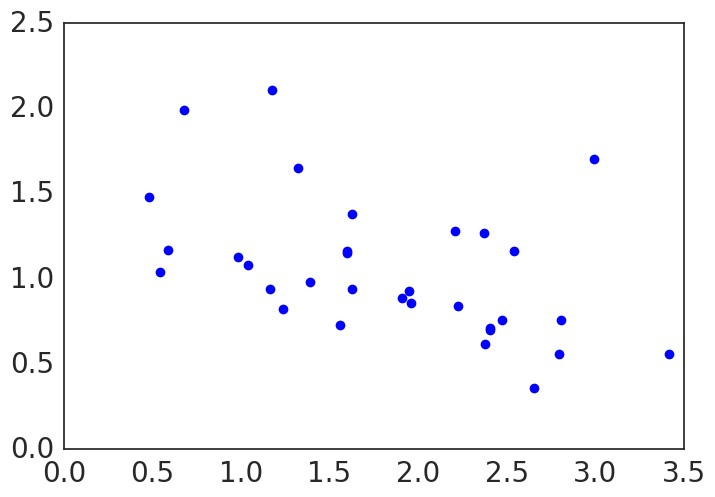

In [202]:
minb = 'y150'
plt.plot(data[minb], data['TLR_2'], 'ob')

In [205]:
taxonomy.loc[[n.name for n in nodes[minb].children[1].tips()]].family.value_counts()

f__Ruminococcaceae    46
Name: family, dtype: int64

In [206]:
taxonomy.loc[[n.name for n in nodes[minb].children[0].tips()]].family.value_counts()

f__Ruminococcaceae    5
Name: family, dtype: int64